# Cleaning the Data

## Data Prep 

### Load Packages

In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
from IPython.display import Image
from ipywidgets import interact, fixed

In [2]:
df = pd.read_csv('Data/2017.csv')
#df.to_parquet('2017.parquet')

In [ ]:
#import pyarrow.parquet as pq
#table = pq.read_table("2017.parquet")
# Optionally convert to Pandas DataFrame
#df = table.to_pandas()

### Manipulate Columns

In [3]:
#Translate column names into english
data = df.rename(columns={
    "hashed_ID_Único":"UniqueID",
    "Data":"Date", 
    "Unidade":"Facility",
    "Grupo EFR":"Payer",
    "Grupo Rúbrica":"SpecificService", 
    "Tipo Rúbrica":"CategoryofService",
    "Sexo":"Sex",
    "Data Nascimento":"BirthYear",
})

In [4]:
data.head()

,Date,Facility,Payer,SpecificService,CategoryofService,BirthYear,Sex,UniqueID
0,14/09/2017,HCIS,ADSE,SERVIÇOS ESPECIAIS CARDIOLOGIA,EXAMES ESPECIAIS,1980.0,Feminino,91e9d2627cd4cc24958988333c4220a3
1,21/08/2017,CCSJM,PARTICULARES,SERVIÇOS E TÉCNICAS GERAIS,EXAMES ESPECIAIS,1980.0,Feminino,91e9d2627cd4cc24958988333c4220a3
2,21/08/2017,CCSJM,PARTICULARES,SERVIÇOS E TÉCNICAS GERAIS,SERVIÇOS E TÉCNICAS GERAIS,1980.0,Feminino,91e9d2627cd4cc24958988333c4220a3
3,18/12/2017,CCTV,ADSE,SERVIÇOS ESPECIAIS UROLOGIA,EXAMES ESPECIAIS,1980.0,Feminino,91e9d2627cd4cc24958988333c4220a3
4,24/04/2017,CCSJM,PARTICULARES,SERVIÇOS ESPECIAIS CARDIOLOGIA,EXAMES ESPECIAIS,1980.0,Feminino,91e9d2627cd4cc24958988333c4220a3


In [5]:
import datetime
data["Date"] = pd.to_datetime(data.Date, errors="coerce") #converting to date time 
data["Age"] = data["Date"].dt.year - data["BirthYear"] # Calculate Approximate Age

In [ ]:
data["Date"]= data["Date"].dt.year

In [ ]:
data.head()

## Delete Uneeded Columns

In [ ]:
del data["BirthYear"]
data.head(2)

## Data Cleaning

In [6]:
data = data[data.Age>=0] #eliminate negative errors 

In [7]:
data.Age.median() #old median
data.Age.mean()

45.92886010773716

In [8]:
age_median = data.loc[data['Age']<110, 'Age'].median()
age_median #median without zero and outliers of 117

46.0

In [9]:
data.loc[data.Age > 110, 'Age'] = np.nan #fill the outliers with nan and replace with median later

### Check for missing values 

In [10]:
n_records = len(data)
def missing_values_df(df):
    for column in df:
        print("{} | {} | {}".format(
            column, len(df[df[column].isnull()]) / (1.0*n_records), df[column].dtype
        ))

missing_values_df(data)

Date | 0.0 | datetime64[ns]
Facility | 0.0 | object
Payer | 8.735618746766296e-05 | object
SpecificService | 0.005830222607331689 | object
CategoryofService | 0.005830222607331689 | object
BirthYear | 0.0 | float64
Sex | 0.002305946419183162 | object
UniqueID | 0.0 | object
Age | 8.751676869462556e-05 | float64


In [11]:
null_data = data[data.isnull().any(axis=1)] #looking to see if the missing values where consistently missing for a single cutsomer
null_data.head(2)

,Date,Facility,Payer,SpecificService,CategoryofService,BirthYear,Sex,UniqueID,Age
19,2017-04-07,HCP,NaN,BLOCO CIRURGIA AMBULATÓRIO,BLOCOS,1980.0,Feminino,91e9d2627cd4cc24958988333c4220a3,37.0
20,2017-04-07,HCP,NaN,BLOCO DE PARTOS,BLOCOS,1980.0,Feminino,91e9d2627cd4cc24958988333c4220a3,37.0


In [12]:
data.Payer = data.Payer.fillna("Missing")
data.SpecificService = data.SpecificService.fillna("Missing")
data.CategoryofService = data.CategoryofService.fillna("Missing")
data.Sex = data.Sex.fillna("Missing")
data.Age = data.Age.fillna(age_median)

#replace missing strings with the string "Missing" 
#missing age/anything above 110 was replaced with the median of values under 110

In [13]:
missing_values_df(data) #no more missing values

Date | 0.0 | datetime64[ns]
Facility | 0.0 | object
Payer | 0.0 | object
SpecificService | 0.0 | object
CategoryofService | 0.0 | object
BirthYear | 0.0 | float64
Sex | 0.0 | object
UniqueID | 0.0 | object
Age | 0.0 | float64


In [14]:
data = data[data.UniqueID != '6bb61e3b7bce0931da574d19d1d82c88'] 
#deleting a virtual customer from the dataset

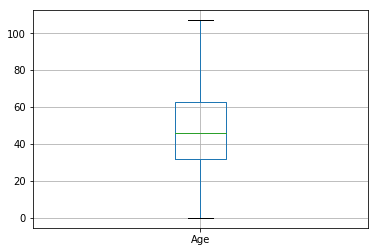

In [15]:
data.boxplot(column='Age')

In [16]:
data.Age.describe()

count    6.227378e+06
mean     4.592265e+01
std      2.212655e+01
min      0.000000e+00
25%      3.200000e+01
50%      4.600000e+01
75%      6.300000e+01
max      1.070000e+02
Name: Age, dtype: float64

### Variable Grouping by Age

In [22]:
data['Age_Group']= 'hi'

In [23]:
data.dtypes

Date                 datetime64[ns]
Facility                     object
Payer                        object
SpecificService              object
CategoryofService            object
BirthYear                   float64
Sex                          object
UniqueID                     object
Age                         float64
Age_Group                    object
dtype: object

In [24]:
data['Age_Group'][(data["Age"]<18) & (data["Age"]>=5)] = "Child"
data['Age_Group'][(data["Age"]>=18) & (data["Age"]<44)] = "YoungAdult"
data['Age_Group'][(data["Age"]>=44) & (data["Age"]<64)] = "Adult"
data['Age_Group'][(data["Age"]>=64) & (data["Age"]<81)] = "Senior"
data['Age_Group'][data["Age"]>=81] = "Elderly"

In [ ]:
data['Age_Group'] = data['Age_Group'].astype('category')

In [25]:
data.dtypes

Date                 datetime64[ns]
Facility                     object
Payer                        object
SpecificService              object
CategoryofService            object
BirthYear                   float64
Sex                          object
UniqueID                     object
Age                         float64
Age_Group                    object
dtype: object

In [26]:
data.head()

,Date,Facility,Payer,SpecificService,CategoryofService,BirthYear,Sex,UniqueID,Age,Age_Group
0,2017-09-14,HCIS,ADSE,SERVIÇOS ESPECIAIS CARDIOLOGIA,EXAMES ESPECIAIS,1980.0,Feminino,91e9d2627cd4cc24958988333c4220a3,37.0,YoungAdult
1,2017-08-21,CCSJM,PARTICULARES,SERVIÇOS E TÉCNICAS GERAIS,EXAMES ESPECIAIS,1980.0,Feminino,91e9d2627cd4cc24958988333c4220a3,37.0,YoungAdult
2,2017-08-21,CCSJM,PARTICULARES,SERVIÇOS E TÉCNICAS GERAIS,SERVIÇOS E TÉCNICAS GERAIS,1980.0,Feminino,91e9d2627cd4cc24958988333c4220a3,37.0,YoungAdult
3,2017-12-18,CCTV,ADSE,SERVIÇOS ESPECIAIS UROLOGIA,EXAMES ESPECIAIS,1980.0,Feminino,91e9d2627cd4cc24958988333c4220a3,37.0,YoungAdult
4,2017-04-24,CCSJM,PARTICULARES,SERVIÇOS ESPECIAIS CARDIOLOGIA,EXAMES ESPECIAIS,1980.0,Feminino,91e9d2627cd4cc24958988333c4220a3,37.0,YoungAdult


### Create a customer dataframe 

In [28]:
patient_visits = data.UniqueID.value_counts(sort=False)

In [29]:
customers = patient_visits.rename_axis('UniqueID').reset_index(name='FrequencyofVisits')
customers.head()

,UniqueID,FrequencyofVisits
0,60c3d0695fc4b9eb81f91c879bed85d2,1
1,5c991cdbb0cf298796fb627b2b711729,3
2,7bee9d628e9fc2450c2540dd09fff602,4
3,c0c54c219d7900711bc8a4aad25a3f34,2
4,053ece419f55be617febdbf590bc7419,3


In [30]:
customers[["Age","Sex"]]= data[["Age","Sex"]]
customers.head()

,UniqueID,FrequencyofVisits,Age,Sex
0,60c3d0695fc4b9eb81f91c879bed85d2,1,37.0,Feminino
1,5c991cdbb0cf298796fb627b2b711729,3,37.0,Feminino
2,7bee9d628e9fc2450c2540dd09fff602,4,37.0,Feminino
3,c0c54c219d7900711bc8a4aad25a3f34,2,37.0,Feminino
4,053ece419f55be617febdbf590bc7419,3,37.0,Feminino


### Export Dataset
Use pickle format so that df reads into notebook faster 

In [32]:
# This is the long format, the transaction table 
data.to_parquet('Data/cleaned_data.parquet')

In [33]:
# This is the wide format, the customer table 
customers.to_parquet("Data/customer_data.parquet")